# Boosted Model with SimplePLS Algorithm Example

This example demonstrates the usage of the `SimplePLS` weaklearner to build a linear model in a forward-stagewise manner. It also provides additional functionality pertaining to linear models that can be used to help with variable selection.

To demonstrate, the `SimplePLS` modeling algorithm that is internal to the library is used for boosting. `SimplePLS` by default will fit a 1-variable linear regression to a dataset, where the single feature used will be the feature with the highest correlation with the target. Refer to the documentation for additional arguments, which allow for the specification of selecting more than one variable or filtering variables that are not as correlated with the target as the most correlated feature. Ill-conditioning due to multicollinearity is not an issue with `SimplePLS`. Furthermore, looking at the order (i.e., the boosting iteration) in which features enter the model provides a simple way to select features.

Logistic regression will be performed in the example using the same dataset that is used in the Binary Target example. Here though, shuffling is turned off so that the informative features are placed as the first columns in the returned dataset.

In [1]:
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.preprocessing import scale

import torch
from torch import tensor

from tboost import BoostedModel
from tboost.weak_learners import SimplePLS
from tboost.link_functions import LogitLink
from tboost.loss_functions import LogLoss

%matplotlib inline

### Create a Dummy Classification Dataset

In [2]:
# generate data sets
X, y = make_classification(
    n_samples=20000,
    n_features=50,
    n_informative=20,
    weights=(0.85, 0.15),
    random_state=11,
    shuffle=False
)
X = scale(X)

# convert numpy arrays to tensors
X = torch.from_numpy(X).to(dtype=torch.float64)
y = torch.from_numpy(y).to(dtype=torch.float64)

### Fit the Model

In [3]:
model = BoostedModel(
    link=LogitLink(),
    loss=LogLoss(),
    model_callback=SimplePLS,
    model_callback_kwargs={},
    alpha=5.0,
    step_type="decaying",
    weights="newton",
    validation_fraction=0.30,
    validation_iter_stop=20,
    validation_stratify=True,
    random_state=13
)
model.fit(X, y, iterations=2000);

### Plot the loss history

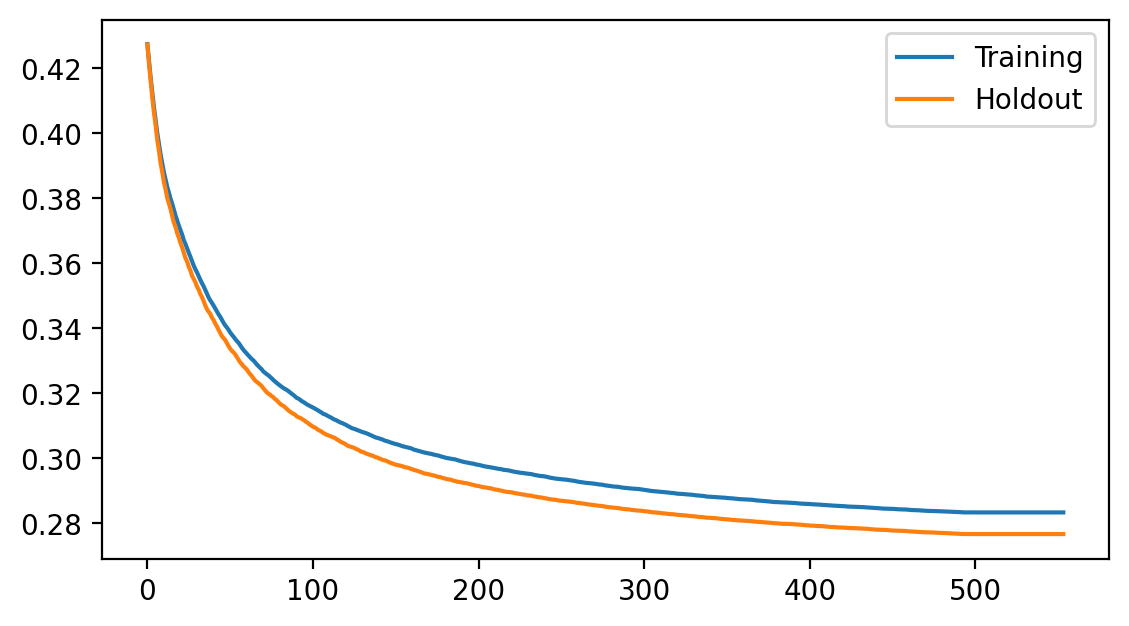

In [4]:
fig = plt.figure(figsize=(6.5, 3.5), dpi=200)
ax = fig.add_subplot(111)
ax.plot(model.get_loss_history(), label=["Training", "Holdout"])
ax.legend(loc="best");

In [5]:
model.get_iterations()

553

### Get and Plot Coefficient History

The coefficients are scaled by the standard deviation of the corresponding features in the data set to get standardized coefficients.

In [6]:
# get the cofficient history and convert plotting values to numpy arrays
coef_history = [np.zeros(X.shape[1])]
for mod, alpha in model:
    coef_history.append(alpha * mod.coef_.detach().numpy())
coef_history = np.array(coef_history).cumsum(axis=0)
coef_history *= X.std(dim=0, unbiased=True, keepdims=True).detach().numpy()

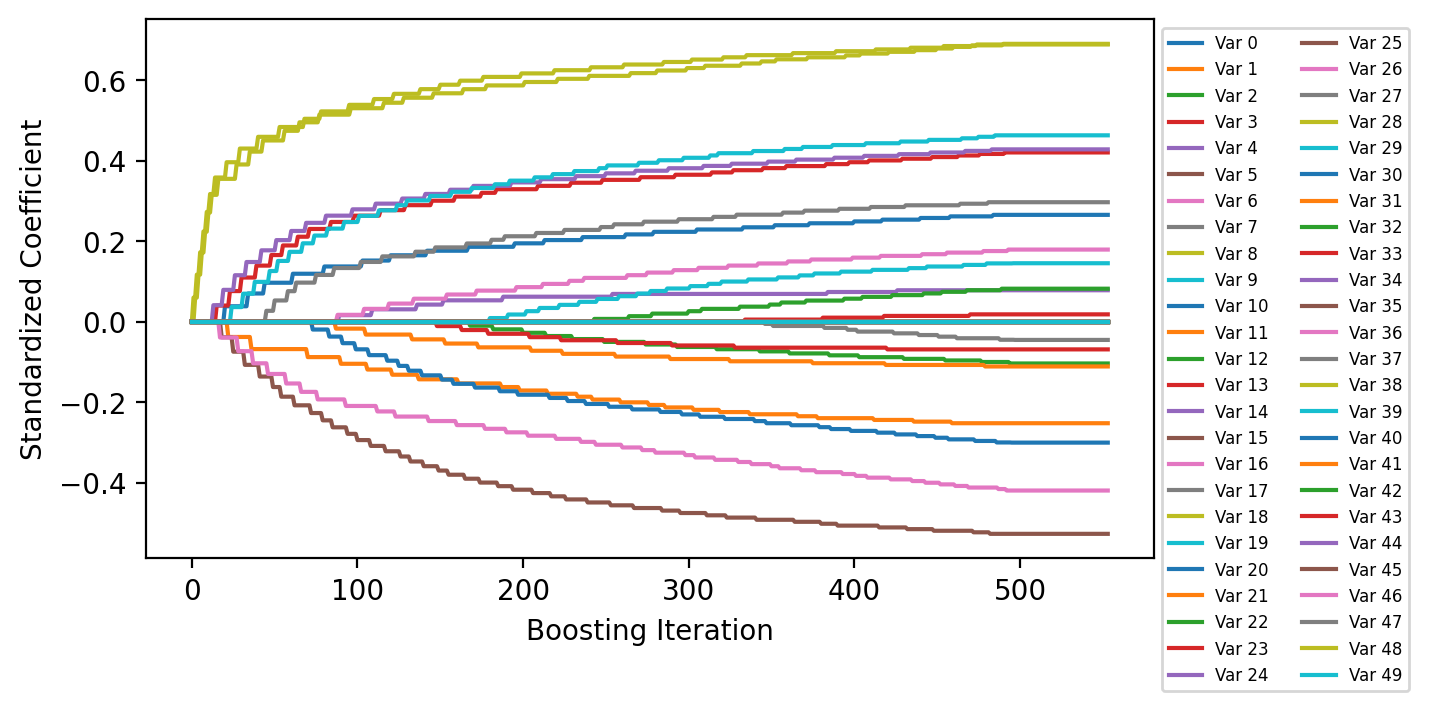

In [7]:
fig = plt.figure(figsize=(6.5, 3.5), dpi=200)
ax = fig.add_subplot(111)
ax.plot(coef_history, label=[f"Var {i:d}" for i in range(X.shape[1])])
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), ncol=2, fontsize=6)
ax.set_xlabel("Boosting Iteration")
ax.set_ylabel("Standardized Coefficient");

### Order that Variables Entered the Model

In [8]:
# get coefficient order from coefficient history
coef_order_dict = OrderedDict()  # type: Dict[int, None]
for coefs in coef_history[1:]:
    nc = (coefs != 0.0).sum()
    order = np.argsort(np.abs(coefs))[::-1].tolist()
    coef_order_dict.update(OrderedDict.fromkeys(order[:nc]))
coef_order = list(coef_order_dict.keys())

In [9]:
coef_order

[8, 18, 14, 3, 6, 5, 0, 1, 19, 17, 10, 11, 16, 4, 13, 2, 9, 12, 33, 7]

In [10]:
print("Number of Selected Variables in the Model: {:d}".format(len(coef_order)))
coef_order

Number of Selected Variables in the Model: 20


[8, 18, 14, 3, 6, 5, 0, 1, 19, 17, 10, 11, 16, 4, 13, 2, 9, 12, 33, 7]

In [11]:
# Order by index number - 19 of the first 20 variables are selected (informative features) and 1 non-informative
sorted(coef_order)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 33]